In [13]:
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from keras import layers
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Question 1

## Step 1 - loading in the data, creating training and validation sets

In [14]:
# loading in the data
panel = pd.read_pickle('returns_chars_panel.pkl') 
macro = pd.read_pickle('macro_timeseries.pkl')

KeyboardInterrupt: 

We are assuming that the returns are already shifted by one period, i.e. each row includes values of features for t=n and in the same row the returns data is for t=n+1. If this isn't the case then the data would need to be offset as just described.

In [4]:
# combine micro and macro data
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro'])

In [6]:
df.tail()

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,ep_macro,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
3739444,2016-08-01,93436,-0.097265,-0.097023,0.000242,0.948225,0.629726,0.627131,0.490549,0.993659,...,-3.210865,0.314661,0.036571,0.000478,0.0030,0.0145,0.0094,0.0164,-0.031614,-0.001618
3739445,2016-09-01,93436,-0.037915,-0.037640,0.000275,0.940011,0.654357,0.651773,0.268347,0.993663,...,-3.201425,0.315197,0.001247,0.000279,0.0030,0.0156,0.0092,0.0156,-0.030723,0.000918
3739446,2016-10-01,93436,-0.031253,-0.030878,0.000375,0.936380,0.650269,0.647670,-0.310701,0.993629,...,-3.192038,0.316794,0.000446,0.001673,0.0029,0.0167,0.0090,0.0005,-0.032543,0.002404
3739447,2016-11-01,93436,-0.042553,-0.042128,0.000425,0.936096,0.638693,0.636094,-0.806963,0.993638,...,-3.152198,0.319688,-0.017958,0.000364,0.0033,0.0187,0.0087,0.0051,-0.028976,0.001247
3739448,2016-12-01,93436,0.127822,0.128247,0.000425,0.929911,0.622969,0.620384,-0.540670,0.993655,...,-3.165980,0.303286,0.035790,0.000946,0.0045,0.0222,0.0085,0.0089,-0.027373,-0.001555


In [7]:
# CREATING DATASETS
# features + targets 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs
y = df['excess_ret']

# make 20 years of training data
date = df['date']
training = (date <= '1977-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values 

# make 10 years of validation data
validation = (date > '1977-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

## Step 2 - selecting optimal hyperparameters

In neural network models, both the depth of the neural network and the number of nodes in each layer is a hyperparameter. For this assignment, the depths of the neural networks are already given and we decided to stick to the number of nodes that have been used in the paper and for more meaningful comparison of results. Therefore the network architectures are as follows:

NN2 architecture: 32, 16, 1

NN3 architecture: 32, 16, 8, 1

NN4 architecture: 32, 16, 8, 4, 1

Where the numbers represent number of nodes in a layer and each layer is separated by the comma. The input layer is not represented on the above and in each case the final layer is the output layer. We follow the paper in using RelU as the activation function in hidden layers and linear in the output layer. The number of epochs is also a hyperparameter that's generally optimized, however we decided to use a model with maximum of 25 epochs and with early stop once the model stops improving for 5 consecutive passes. This was a decision we took after analysing the graphs which showed that for most models the validation performance flatlined after around 15 epochs thus we decided that 25 epochs is more than sufficient. Finally, the optimization was to pick the model which would provide smallest MSE in the validation set.

We perform the most extensive search for the NN2 network given that it's the least computationally expensive and therefore takes fastest to do. For NN3 and NN4 models, we streamline the process based on our experience from optimizing the hyperparameters of the NN2 model, as we assume that in general the results will hold. We acknowledge that this isn't a perfect assumption, and a combination which yielded very bad results for the NN2 model may work well for NN3 or NN4 models. However, this is due to computational and time constraints, and we believe that we're appropriately thorough in our selection anyways. We provide further details about the hyperparameter selection process for individual models in the following sections.

### Optimizing NN2 model

The NN2 model is the least computationally expensive and therefore we test the most combinations of hyperparameters. The hyperparameters that we're adjusting are: batch size, learning rate, batch normalization and lambda for l1 regularization.
We opt for a simplified gridsearch process, batch normalization is a binary (i.e. we either use it or don't) whereas for lr, batch size and lambda we test three different values. If we were to use full gridsearch process this would require us to run the model 2*3^3=54 times. Therefore we first test all combinations of batch size and learning rate. We then pick the best two models and run them with batch normalization and three different values of lambda. We noticed a decrease in performance, we then ran some other models with different combinations of lambda and batch normalization (not reported) and noticed that batch normalization decreases the performance of the models. Finally, we tested the two best performing models with no batch-normalization and three different learning rates and obtained the best performing model out of all combinations that we have tested. We also noticed that in the combination with batch_size = 256 and lr=1e-5 the performance was improving as lambda was decreasing so we also tried lambda = 1e-3 but it performed worse, hence why we decided that the model with lambda=1e-4 is the best performing model.

Exact results are reported in a table after the code

In [49]:
# FINDING RIGHT HYPERPARAMETERS AND MODEL SPECIFICATION
tf.random.set_seed(999) # setting the seed for replicatability

# Hypers
batch_size = 256
learning_rate = 1e-5
lamda = 1e-4
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


# Model architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1],  # input_dim specified for the first layer
                activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))
#model.add(BatchNormalization()) 

model.add(Dense(16, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))
#model.add(BatchNormalization())  

model.add(Dense(1, activation='linear',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

# Optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mse', 
              optimizer=optimizer,  # Use the optimizer with specified learning rate
              metrics=['mse'])

# Training the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=batch_size, 
                    verbose=True,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

# Evaluate the model
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)

print(f"Training MSE: {mse_train[1]}")
print(f"Validation MSE: {mse_val[1]}")

Epoch 1/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.5983 - mse: 0.1176 - val_loss: 0.4982 - val_mse: 0.0602
Epoch 2/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.4589 - mse: 0.0368 - val_loss: 0.4114 - val_mse: 0.0388
Epoch 3/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.3805 - mse: 0.0251 - val_loss: 0.3348 - val_mse: 0.0312
Epoch 4/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.3079 - mse: 0.0210 - val_loss: 0.2668 - val_mse: 0.0283
Epoch 5/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.2432 - mse: 0.0195 - val_loss: 0.2093 - val_mse: 0.0271
Epoch 6/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.1886 - mse: 0.0188 - val_loss: 0.1616 - val_mse: 0.0267
Epoch 7/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1434 - mse: 0.0186 - val_loss: 0.1238 - val_mse: 0.0266
Epoch 8/25
2816/2816 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1079 - mse: 0.0185 - val_loss: 0.0948 - val_mse: 0.0265
Epoch 9/25
2816/2816 ━━━━━━━━━━━

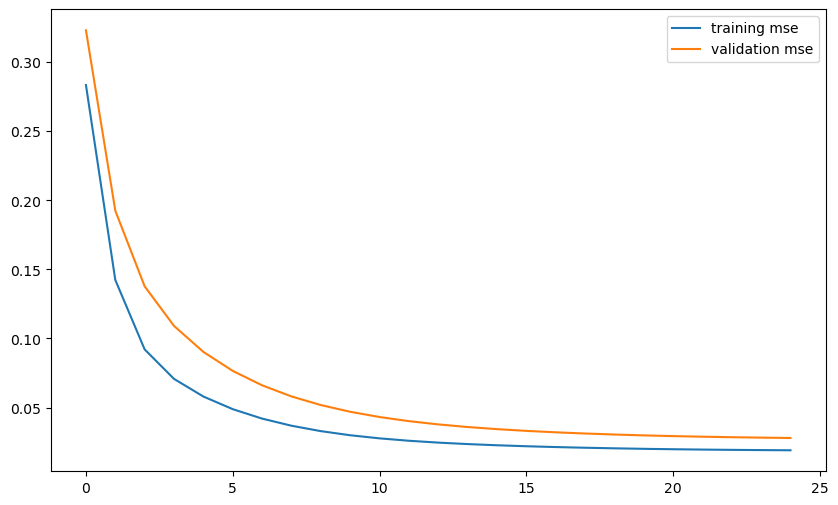

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
pd.Series(history.history['mse']).plot(ax=ax, label='training mse')
pd.Series(history.history['val_mse']).plot(ax=ax, label='validation mse')
ax.legend()

In [ ]:
Results (no lambda and batch normalization initially):
batch = 256, lr = 1e-3, epochs = 6/25; validation MSE = 0.02907363325357437
batch = 512, lr = 1e-3, epochs = 9/25; validation MSE = 0.02852504514157772
batch = 1024, lr = 1e-3, epochs = 8/25; validation MSE = 0.027601296082139015

batch = 256, lr = 1e-4, epochs = 1O/25; validation MSE = 0.02680022269487381
batch = 512, lr = 1e-4, epochs = 12/25; validation MSE = 0.026700353249907494 2nd best - round 1
batch = 1024, lr = 1e-4, epochs = 25/25; validation MSE = 0.02671683393418789

batch = 256, lr = 1e-5, epochs = 25/25; validation MSE = 0.026673775166273117 WINNER - round 1
batch = 512, lr = 1e-5, epochs = 25/25; validation MSE = 0.026739517226815224
batch = 1024, lr = 1e-5, epochs = 25/25; validation MSE = 0.027967121452093124

Adding lambda and batch normalization to the 2 models that worked best initially lambda:
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-4; validation MSE = 0.026738665997982025
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-5; validation MSE = 0.027124900370836258
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-6; validation MSE = 0.02796582691371441

batch = 512, lr = 1e-4, epochs = 21/25, lambda = 1e-4; validation MSE = 0.03449607640504837
batch = 512, lr = 1e-4, epochs = 25/25, lambda = 1e-5; validation MSE = 0.026746831834316254
batch = 512, lr = 1e-4, epochs = 25/25, lambda = 1e-6; validation MSE = 0.026684550568461418 


Lambda but no batch normalization for the 2 best models:
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-3; validation MSE = 0.026455456390976906
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-4; validation MSE = 0.026391010731458664 OVERALL WINNER
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-5; validation MSE = 0.02645077370107174
batch = 256, lr = 1e-5, epochs = 25/25, lambda = 1e-6; validation MSE = 0.026525743305683136

batch = 512, lr = 1e-4, epochs = 25/25, lambda = 1e-4; validation MSE = 0.026469042524695396
batch = 512, lr = 1e-4, epochs = 25/25, lambda = 1e-5; validation MSE = 0.026829596608877182
batch = 512, lr = 1e-4, epochs = 25/25, lambda = 1e-6; validation MSE = 0.02674420364201069

### Optimizing NN3 model

In [84]:
# FINDING RIGHT HYPERPARAMETERS AND MODEL SPECIFICATION
tf.random.set_seed(999) # setting the seed for replicatability

# Hypers
batch_size = 256
learning_rate = 1e-5
lamda = 1e-4
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


# Model architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1],  # input_dim specified for the first layer
                activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(16, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(8, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(1, activation='linear',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

# Optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mse', 
              optimizer=optimizer,  # Use the optimizer with specified learning rate
              metrics=['mse'])

# Training the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=15, 
                    batch_size=batch_size, 
                    verbose=True,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

# Evaluate the model
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)

print(f"Training MSE: {mse_train[1]}")
print(f"Validation MSE: {mse_val[1]}")

C:\Users\krspl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1173 - mse: 0.0670 - val_loss: 0.0790 - val_mse: 0.0319
Epoch 2/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0731 - mse: 0.0275 - val_loss: 0.0678 - val_mse: 0.0275
Epoch 3/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0630 - mse: 0.0247 - val_loss: 0.0582 - val_mse: 0.0266
Epoch 4/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.0535 - mse: 0.0242 - val_loss: 0.0490 - val_mse: 0.0265
Epoch 5/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0446 - mse: 0.0241 - val_loss: 0.0412 - val_mse: 0.0264
Epoch 6/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0373 - mse: 0.0241 - val_loss: 0.0355 - val_mse: 0.0264
Epoch 7/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0321 - mse: 0.0241 - val_loss: 0.0318 - val_mse: 0.0264
Epoch 8/15
5840/5840 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0288 - mse: 0.0241 - val_loss: 0.0297 - val_mse: 0.0264
Epoch 9/15
5840/5840 ━━━━━━━━━━━

### Optimizing NN4 model

In [ ]:
# FINDING RIGHT HYPERPARAMETERS AND MODEL SPECIFICATION
tf.random.set_seed(999) # setting the seed for replicatability

# Hypers
batch_size = 256
learning_rate = 1e-5
lamda = 1e-6
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


# Model architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1],  # input_dim specified for the first layer
                activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(16, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(8, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(4, activation='relu',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

model.add(Dense(1, activation='linear',
                kernel_regularizer = L1(lamda),
                kernel_initializer='he_normal'))

# Optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='mse', 
              optimizer=optimizer,  # Use the optimizer with specified learning rate
              metrics=['mse'])

# Training the model with early stopping
history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=batch_size, 
                    verbose=True,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

# Evaluate the model
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)

print(f"Training MSE: {mse_train[1]}")
print(f"Validation MSE: {mse_val[1]}")

## Step 2 - predicting returns

In the previous step we have found the optimal model specification. We are now defining the optimal models inside a function for clarity of the code within the loops.

In [9]:
def create_nn2_model(input_dim): 
    # Hypers
    learning_rate = 1e-5
    lamda = 1e-4
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Specify input shape using Input layer
    model.add(Dense(32, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    model.add(Dense(16, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    model.add(Dense(1, activation='linear',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    # Optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=['mse'])

    return model

In [10]:
def create_nn3_model(input_dim): 
    learning_rate = 1e-5
    lamda = 1e-4
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Specify input shape using Input layer
    model.add(Dense(32, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    model.add(Dense(16, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))
    
    model.add(Dense(8, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))
    
    model.add(Dense(1, activation='linear',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    # Optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=['mse'])

    return model

In [11]:
def create_nn4_model(input_dim): 
    learning_rate = 1e-5
    lamda = 1e-6
    
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Specify input shape using Input layer
    model.add(Dense(32, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    model.add(Dense(16, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))
    
    model.add(Dense(8, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    model.add(Dense(4, activation='relu',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))
    
    model.add(Dense(1, activation='linear',
                    kernel_regularizer = L1(lamda),
                    kernel_initializer='he_normal'))

    # Optimizer with specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='mse', 
                  optimizer=optimizer, 
                  metrics=['mse'])

    return model

# Question 2

In [ ]:
#Getting predictions for nn2
input_dim = X_train.shape[1]  # Number of input features
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

predictions_list_nn2 = [] 

start_time = time.time()

for year in range(1987,2016): 
    nn2_model = create_nn2_model(input_dim) # Initializing the model
    # Selecting appropriate years for training the model
    training = (date <= str(year)+'-12')
    X_train, y_train = X.loc[training].values, y.loc[training].values

    # Selecting the subset for which we need to predict value i.e. the next 12 months
    prediction = (date >= str(year+1)+'-01') & (date <= str(year+1)+'-12')
    X_pred = X.loc[prediction].values 
    
    # Fitting the model using the training data - we pass here the optimal hyperparameters
    nn2_model.fit(X_train, y_train, epochs=25, batch_size=256, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Using the model for predictions
    predictions_temp = nn2_model.predict(X_pred)
    predictions_list_nn2.append(predictions_temp)
    print(year)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(elapsed_time)

predictions_array_nn2 = np.concatenate(predictions_list_nn2)

2631/2631 [==============================] - 1s 423us/step
1987
2558/2558 [==============================] - 1s 403us/step
1988
2525/2525 [==============================] - 1s 535us/step
1989
2494/2494 [==============================] - 1s 419us/step
1990
2551/2551 [==============================] - 1s 431us/step
1991
2705/2705 [==============================] - 1s 427us/step
1992
2989/2989 [==============================] - 1s 412us/step
1993
3075/3075 [==============================] - 1s 415us/step
1994
3248/3248 [==============================] - 1s 440us/step
1995
3376/3376 [==============================] - 2s 454us/step
1996
3337/3337 [==============================] - 2s 590us/step
1997


In [9]:
#Getting predictions for nn3
input_dim = X_train.shape[1]  # Number of input features
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

predictions_list_nn3 = [] 

start_time = time.time()

for year in range(1987,2016): 
    nn3_model = create_nn3_model(input_dim) # Initializing the model
    # Selecting appropriate years for training the model
    training = (date <= str(year)+'-12')
    X_train, y_train = X.loc[training].values, y.loc[training].values

    # Selecting the subset for which we need to predict value i.e. the next 12 months
    prediction = (date >= str(year+1)+'-01') & (date <= str(year+1)+'-12')
    X_pred = X.loc[prediction].values 
    
    # Fitting the model using the training data
    nn3_model.fit(X_train, y_train, epochs=15, batch_size=256, validation_split=0.2, verbose=0)

    # Using the model for predictions
    predictions_temp = nn3_model.predict(X_pred)
    predictions_list_nn3.append(predictions_temp)
    print(year)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(elapsed_time)

predictions_array_nn3 = np.concatenate(predictions_list_nn3)

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1987
2558/2558 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1988
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1989
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1990
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1991
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1992
2989/2989 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1993
3075/3075 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1994
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1995
3376/3376 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1996
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1997
3155/3155 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1998
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1999
2884/2884 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2000
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2001
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2002
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2003
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2004
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2005
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2006
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/st

In [7]:
#Getting predictions for nn4
input_dim = X_train.shape[1]  # Number of input features
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

predictions_list_nn4 = [] 

start_time = time.time()

for year in range(1987,2016): 
    nn4_model = create_nn4_model(input_dim) # Initializing the model
    # Selecting appropriate years for training the model
    training = (date <= str(year)+'-12')
    X_train, y_train = X.loc[training].values, y.loc[training].values

    # Selecting the subset for which we need to predict value i.e. the next 12 months
    prediction = (date >= str(year+1)+'-01') & (date <= str(year+1)+'-12')
    X_pred = X.loc[prediction].values 
    
    # Fitting the model using the training data
    nn4_model.fit(X_train, y_train, epochs=15, batch_size=256, validation_split=0.2, verbose=0)

    # Using the model for predictions
    predictions_temp = nn4_model.predict(X_pred)
    predictions_list_nn4.append(predictions_temp)
    print(year)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(elapsed_time)

predictions_array_nn4 = np.concatenate(predictions_list_nn4)

2631/2631 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1987
2558/2558 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1988
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1989
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1990
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1991
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1992
2989/2989 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1993
3075/3075 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1994
3248/3248 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1995
3376/3376 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1996
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1997
3155/3155 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1998
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1999
2884/2884 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2000
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2001
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2002
2497/2497 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2003
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2004
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2005
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2006
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

### NN2 R-squared

In [80]:
# Creating a dataframe with actual returns and predictions only for the testing period timeframe
evaluation_range = (date >= '1988-01') & (date <= '2016-12')
evaluation_df = df[['date','permno', 'excess_ret']].copy()
evaluation_df = evaluation_df.loc[evaluation_range]
evaluation_df['pred_y'] = predictions_array_nn2
evaluation_df.to_csv('Q2_nn2_results.csv', index=False)

In [81]:
# Creating columns which contain the elements to be summed for the OOS R-squared formula
evaluation_df['MSE'] = (evaluation_df['excess_ret'] - evaluation_df['pred_y'])** 2
evaluation_df['excess_ret_sq'] = evaluation_df['excess_ret'] ** 2

#Calculating the R-squared for all companies combined
R_sq = 1 - sum(evaluation_df['MSE']) / sum(evaluation_df['excess_ret_sq'])
print(R_sq)

-0.0048500523400141216


### NN3 R-squared

In [10]:
# Creating a dataframe with actual returns and predictions only for the testing period timeframe
evaluation_range = (date >= '1988-01') & (date <= '2016-12')
evaluation_df_nn3 = df[['date','permno', 'excess_ret']].copy()
evaluation_df_nn3 = evaluation_df_nn3.loc[evaluation_range]
evaluation_df_nn3['pred_y'] = predictions_array_nn3
evaluation_df_nn3.to_csv('Q2_nn3_results.csv', index=False)

In [11]:
# Creating columns which contain the elements to be summed for the OOS R-squared formula
evaluation_df_nn3['MSE'] = (evaluation_df_nn3['excess_ret'] - evaluation_df_nn3['pred_y'])** 2
evaluation_df_nn3['excess_ret_sq'] = evaluation_df_nn3['excess_ret'] ** 2

#Calculating the R-squared for all companies combined
R_sq_nn3 = 1 - sum(evaluation_df_nn3['MSE']) / sum(evaluation_df_nn3['excess_ret_sq'])
print(R_sq_nn3)

0.0004915190023231375


### NN4 R-Squared

In [8]:
# Creating a dataframe with actual returns and predictions only for the testing period timeframe
evaluation_range = (date >= '1988-01') & (date <= '2016-12')
evaluation_df_nn4 = df[['date','permno', 'excess_ret']].copy()
evaluation_df_nn4 = evaluation_df_nn4.loc[evaluation_range]
evaluation_df_nn4['pred_y'] = predictions_array_nn4
evaluation_df_nn4.to_csv('Q2_nn4_results.csv', index=False)

# Creating columns which contain the elements to be summed for the OOS R-squared formula
evaluation_df_nn4['MSE'] = (evaluation_df_nn4['excess_ret'] - evaluation_df_nn4['pred_y'])** 2
evaluation_df_nn4['excess_ret_sq'] = evaluation_df_nn4['excess_ret'] ** 2

#Calculating the R-squared for all companies combined
R_sq_nn4 = 1 - sum(evaluation_df_nn4['MSE']) / sum(evaluation_df_nn4['excess_ret_sq'])
print(R_sq_nn4)

-0.0008382474246113603


# Question 3

In [16]:
def get_predictions_nn3(X, y, start, end):
    input_dim = X.shape[1]  # Number of input features

    predictions_list = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    for year in range(start, end): 
        nn3_model = create_nn3_model(input_dim) # Initializing the model
        # Selecting appropriate years for training the model
        training = (date <= str(year)+'-12')
        X_train, y_train = X.loc[training].values, y.loc[training].values

        # Selecting the subset for which we need to predict value i.e. the next 12 months
        prediction = (date >= str(year+1)+'-01') & (date <= str(year+1)+'-12')
        X_pred = X.loc[prediction].values 

        # Fitting the model using the training data
        nn3_model.fit(X_train, y_train, epochs=15, batch_size=256, validation_split=0.2, callbacks=[early_stopping], verbose=0)

        # Using the model for predictions
        predictions_temp = nn3_model.predict(X_pred)
        predictions_list.append(predictions_temp)
        
        del nn3_model, X_train, y_train, X_pred, predictions_temp
        gc.collect()

        
    predictions_array = np.concatenate(predictions_list)
    return predictions_array

In [12]:
def get_oos_rsq(predictions, start, end):
    # Creating a dataframe with actual returns and predictions only for the testing period timeframe
    date_range = (date >= str(start+1)+'-01') & (date <= str(end+1)+'-12')
    evaluation_df = df_q3[['excess_ret']].loc[date_range].copy()
    evaluation_df['pred_y'] = predictions
      
    # Creating columns which contain the elements to be summed for the OOS R-squared formula
    evaluation_df['MSE'] = (evaluation_df['excess_ret'] - evaluation_df['pred_y'])** 2
    evaluation_df['excess_ret_sq'] = evaluation_df['excess_ret'] ** 2
    
    #Calculating the R-squared for all companies combined
    R_sq = 1 - sum(evaluation_df['MSE']) / sum(evaluation_df['excess_ret_sq'])
    return R_sq

In [13]:
date_filter_q3 = (date >= '1990-01') & (date <= '2003-12')
df_q3 = df.loc[date_filter_q3]

# Apply the filter to X and y
X_q3 = df_q3.drop(columns=['ret', 'excess_ret', 'rfree', 'permno', 'date']) # everything except return info and IDs
y_q3 = df_q3['excess_ret']

In [22]:
R_squared_list = []

for column in range(0, 105):
    time_s = time.time()
    
    column_label = X_q3.columns[column]
    temp_X = X_q3.drop(column_label, axis=1)

    temp_predictions = get_predictions_nn3(temp_X, y_q3, 2000, 2003)
    temp_r_sq = get_oos_rsq(temp_predictions, 2000, 2003)
    
    R_squared_list.append(temp_r_sq)
    
    del temp_X, temp_predictions, temp_r_sq
    gc.collect()
    
    time_e = time.time()
    print('Finished column: '+str(column), '  |Seconds elapsed on col:' + str(time_e-time_s))


# Convert the list of arrays (predictions_list) to a DataFrame
R_squared_df = pd.DataFrame(R_squared_list, columns=['R_squared'])

R_squared_df.to_csv('Q3_R_sq.csv', index=False)

2884/2884 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Finished column: 103 Secodns elapsed on col:288.5442657470703
2884/2884 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2688/2688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2535/2535 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Finished column: 104 Secodns elapsed on col:275.1575810909271


# Question 4

In [ ]:
# initialise
lasso = Lasso()

# hyperparameter panel to tune
param_grid_lasso = {'alpha': [0.1, 0.5, 1, 5, 10]}
# gridsearch for hyperparameter tuning
grid_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, scoring='neg_mean_squared_error', cv=3)

In [ ]:
# lasso results
grid_result_lasso = grid_lasso.fit(X_train, y_train)

# optimal hyperparameters
best_alpha = grid_result_lasso.best_params_['alpha']
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)
y_pred_lasso = lasso_best.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = 1 - (mse_lasso / np.var(y_test))

In [ ]:
# compare Lasso with NN results

print(f"LASSO OOS MSE: {mse_lasso}")
print(f"LASSO OOS R²: {r2_lasso}")

# Appendix

In [ ]:
# Getting OOS R-squared for each company
unique_company = evaluation_df['permno'].unique()
R_sq_list = []

for company in unique_company:
    company_df = evaluation_df[evaluation_df['permno'] == company]
    mse_sum = company_df['MSE'].sum()
    ret_sq_sum = company_df['excess_ret_sq'].sum()
    
    # Ensure no division by zero
    if ret_sq_sum == 0:
        R_sq_temp = float('nan')  # or handle as appropriate
    else:
        R_sq_temp = 1 - mse_sum / ret_sq_sum
    
    R_sq_list.append((company, R_sq_temp))

In [ ]:
#%% Big Data 2 assignment code records
# created by Adelina C.ZF. at 7/6/2024
# A second approach to solve the assignment
# using grid search for hyperparameter tuning instead of manual comparison. did not use due to hardware constraints
# Import necessary libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

#%% Load data
# import datasets from provided files
panel = pd.read_pickle('returns_chars_panel.pkl') 
macro = pd.read_pickle('macro_timeseries.pkl')
# merge micro and macro dataset
df = pd.merge(panel,macro,on='date',how='left',suffixes=['','_macro'])

#%% train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)  # set seed for reproducability

#%% Hyperparameter tuning
# NN model with various hidden layers - self-defined function
def create_model(neurons=64, dropout_rate=0.2, layers=2):
    model = Sequential()  # note randomness here at initialisation - double check later for optimal results
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))  #take inputs from parameter panel for tuning later
    model.add(Dropout(dropout_rate))
    for _ in range(layers-1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # adam optimiser, loss function take MSE
    return model

# import keras regressor to implement self-defined function above
from keras.wrappers.scikit_learn import KerasRegressor
# fit model
model_nn = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'batch_size': [216, 512, 1024],   ####note might need update after running to search for optimal results
    'epochs': [25, 50],
    'neurons': [64, 128],
    'dropout_rate': [0.0, 0.2],
    'layers': [2, 3, 4]
}

#%% hyperparameter tuning using gridsearch powered by keras regressor
grid_nn = GridSearchCV(estimator=model_nn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result_nn = grid_nn.fit(X_train, y_train)

# tuning results
best_params = grid_result_nn.best_params_
best_model = create_model(neurons=best_params['neurons'], dropout_rate=best_params['dropout_rate'], layers=best_params['layers'])
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# OOS results
y_pred = best_model.predict(X_test)
mse_oos = mean_squared_error(y_test, y_pred)
r2_oos = 1 - (mse_oos / np.var(y_test))

print(f"Best parameters: {best_params}")
print(f"OOS MSE: {mse_oos}")
print(f"OOS R²: {r2_oos}")